<a href="https://colab.research.google.com/github/Lirikman/neural_networks/blob/main/word%20processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ЦЕЛЬ** - написать модель классификации писателей Русской литературы

### Загрузка данных

Процесс обучения начинается с загрузки датасетов и подключения необходимых библиотек.

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/russian_literature.zip

--2025-04-07 13:48:12--  https://storage.yandexcloud.net/academy.ai/russian_literature.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21547079 (21M) [application/x-zip-compressed]
Saving to: ‘russian_literature.zip’

russian_literature. 100%[===================>]  20.55M  5.94MB/s    in 3.7s    

2025-04-07 13:48:17 (5.53 MB/s) - ‘russian_literature.zip’ saved [21547079/21547079]



In [ ]:
# Разархивируем датасета во временную папку 'dataset'
!unzip -qo "russian_literature" -d ./dataset

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Ф╨╛╨║╨╗╨░╨┤, ╨┐╤А╨╕╨│╨╛╤В╨╛╨▓╨╗╨╡╨╜╨╜╤Л╨╣ ╨┤╨╗╤П ╨║╨╛╨╜╨│╤А╨╡╤Б╤Б╨░ ╨╛ ╨╝╨╕╤А╨╡ ╨▓ ╨б╤В╨╛╨║╨│╨╛╨╗╤М╨╝╨╡.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Я╨╛╤З╨╡╨╝╤Г ╤Е╤А╨╕╤Б╤В╨╕╨░╨╜╤Б╨║╨╕╨╡ ╨╜╨░╤А╨╛╨┤╤Л ╨▓╨╛╨╛╨▒╤Й╨╡ ╨╕ ╨▓ ╨╛╤Б╨╛╨▒╨╡╨╜╨╜╨╛╤Б╤В╨╕ ╤А╤Г╤Б╤Б╨║╨╕╨╣ ╨╜╨░╤Е╨╛╨┤╤П╤В╤Б╤П ╤В╨╡╨┐╨╡╤А╤М ╨▓ ╨▒╨╡╨┤╤Б╤В╨▓╨╡╨╜╨╜╨╛╨╝ ╨┐╨╛╨╗╨╛╨╢╨╡╨╜╨╕╨╕.txt
        File name too long


В папке прозы представлены 11 писателей.

In [ ]:
!dir ./dataset/prose

Blok  Bryusov  Chekhov	Dostoevsky  Gogol  Gorky  Herzen  Lermontov  Pushkin  Tolstoy  Turgenev


В папке поэмы представленны 4 писателя.

In [ ]:
!dir ./dataset/poems

Blok  Lermontov  Nekrasov  Pushkin


Пробежимся по папкам и соберем датасеты из всех найденных произведений в обеих папках в один общий словарь, где ключ -  это писатель, а значение - все его произведения одним сплошным текстом.

In [ ]:
# Загрузка необходимых библиотек
import glob # Вспомогательный модуль для работы с файловой системой
import numpy as np
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок


# Выбираем их явно, чтобы список был перед глазами, и отложилось в голове, что имена писателей (точнее их порядковый номер) - это метки
CLASS_LIST=["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Lermontov", "Blok", "Pushkin", "Gogol", "Gorky", "Herzen", "Bryusov", "Nekrasov" ]

all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
  all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
  for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
    with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
                # Загрузка содержимого файла в строку
                text = f.read()

    all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

In [ ]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in all_texts.values())
print(f'Датасет состоит из {total} символов')

Датасет состоит из 38146925 символов


In [ ]:
print('Общая выборка по писателям:')
for author in CLASS_LIST:
    # удобный метод форматирования 2 знака после запятой f'{ВЫРАЖЕНИЕ:.2f}'
    print(f'{author} - {len(all_texts[author])} символов, доля в общей базе: {len(all_texts[author])/total*100 :.2f}%')

Общая выборка по писателям:
Dostoevsky - 11221679 символов, доля в общей базе: 29.42%
Tolstoy - 9392435 символов, доля в общей базе: 24.62%
Turgenev - 2345243 символов, доля в общей базе: 6.15%
Chekhov - 1834330 символов, доля в общей базе: 4.81%
Lermontov - 364382 символов, доля в общей базе: 0.96%
Blok - 604204 символов, доля в общей базе: 1.58%
Pushkin - 1399557 символов, доля в общей базе: 3.67%
Gogol - 2196599 символов, доля в общей базе: 5.76%
Gorky - 4324025 символов, доля в общей базе: 11.34%
Herzen - 1282316 символов, доля в общей базе: 3.36%
Bryusov - 2830897 символов, доля в общей базе: 7.42%
Nekrasov - 351258 символов, доля в общей базе: 0.92%


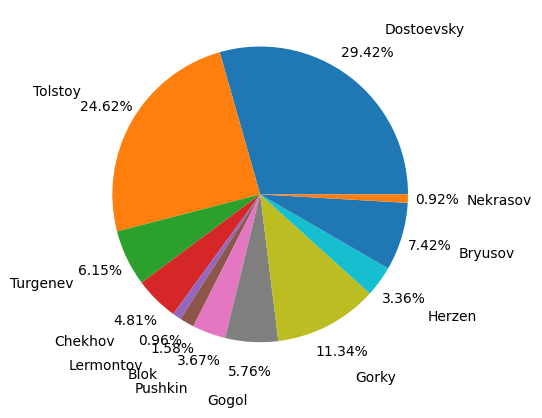

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
ax.pie([len(i) for i in all_texts.values()], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

Из диаграммы видно, что наш датасет сильно разбалансирован по символам. Его необходимо сбалансировать, но сначала мы займёмся процессом токенизации, чтобы не потерять части слов.

### Токенизация

Для разбиения текста на слова, воспользуемся токенизатором Razdel, который является частью проекта Natasha. Затем посторим частотный словарь.

In [ ]:
!pip install razdel # установка библиотеки Razdel

In [ ]:
from razdel import tokenize

# Разбиваем текст на токены (слова, символы)
all_tokens = {}
for author, text in all_texts.items():
  all_tokens[author] = [token.text for token in tokenize(text)]

Мы создали словарь all_tokens, где ключ - это автор, а значение - слова. Токенизатор Razdel разбил весь текст на слова и символы.

In [ ]:
print('Всего слов и символов в словаре:', sum([len(i) for i in all_tokens.values()]))

Всего слов и символов в словаре: 7595948


In [ ]:
# Приведём все слова к нижнему регистру и исключим все символы
all_words = {}
for author, text in all_tokens.items():
  all_words[author] = [i.lower() for i in text if i.isalpha()]

In [ ]:
# Найдём количество уникальных слов в словаре all_words
print('Всего слов в словаре:', sum([len(i) for i in all_words.values()]))
print('Количество уникальных слов в словаре:', len(set([j for i in all_words.values() for j in i])))

Всего слов в словаре: 5795979
Количество уникальных слов в словаре: 244423


Подсчитаем частоту слов в тексте и отсортируем в порядке убывания:

In [ ]:
from collections import Counter
all_words_count = [word for words in all_words.values() for word in words]
word_count = Counter(all_words_count)
sorted_words = word_count.most_common()

In [ ]:
print('Первые 10 часто встречающихся слов:', sorted_words[:10])
print('Размер словаря:', len(sorted_words))

Первые 10 часто встречающихся слов: [('и', 261868), ('в', 141602), ('не', 121368), ('что', 93962), ('я', 89767), ('на', 82553), ('он', 71854), ('с', 68129), ('как', 51095), ('а', 45840)]
Размер словаря: 244423


In [ ]:
# Создадим словарь со словами и индексами слов по отсортированному списку sorted_words
# Размер словаря зададим 20000 слов
word_index = {}
word_index['неизвестное_слово'] = 0
for i in range(0, 19999):
  word_index[sorted_words[i][0]] = i+1

In [ ]:
# Выведем первые 10 значений словаря с индексами слов
print(list(word_index.items())[:10])

[('неизвестное_слово', 0), ('и', 1), ('в', 2), ('не', 3), ('что', 4), ('я', 5), ('на', 6), ('он', 7), ('с', 8), ('как', 9)]


Как можно увидеть, неизвестное слово помечено индексом 0, соответственно все редкие слова, которые выходят за размер словаря будут помечены индексом 0.

In [ ]:
# Переведём весь текст датасета в последовательность индексов
# seq_train = [[word_index.get(word, 0) for word in text]
#               for author, text in all_words.items()]
cls = CLASS_LIST.index(author)
seq_train = [[] for _ in range(len(CLASS_LIST))]
for cls, (author, text) in enumerate(all_words.items()):
  for word in text:
    if word in word_index.keys():
      seq_train[cls].append(word_index[word])
    else:
      seq_train[cls].append(0)

In [ ]:
# Проверка индекса слова в словаре
try:
    print('Вы ввели слово с индексом:', word_index[input('Введите слово (в нижнем регистре): ')])
except:
    print('Такого слова нет в словаре слова нет в словаре')

Введите слово (в нижнем регистре): я
Вы ввели слово с индексом: 5


In [ ]:
author = "Pushkin"
cls = CLASS_LIST.index(author)

print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", all_texts[author][:120])
print("Он же в виде последовательности индексов: ", seq_train[cls][:20])

Фрагмент обучающего текста:
В виде оригинального текста:                Александр Пушкин ЕГИПЕТСКИЕ НОЧИ ГЛАВА I — Quel est cet homme? — На c'est un bien grand talent, il fait de sa voix tout
Он же в виде последовательности индексов:  [2060, 3274, 0, 609, 976, 519, 19753, 841, 15768, 5276, 6, 1446, 841, 1470, 4510, 8091, 0, 1173, 6707, 463]


In [ ]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 5795979 слов


In [ ]:
print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Dostoevsky - 1727703 слов, доля в общей базе: 29.81%
Tolstoy - 1421368 слов, доля в общей базе: 24.52%
Turgenev - 357377 слов, доля в общей базе: 6.17%
Chekhov - 285146 слов, доля в общей базе: 4.92%
Lermontov - 54348 слов, доля в общей базе: 0.94%
Blok - 86723 слов, доля в общей базе: 1.50%
Pushkin - 210584 слов, доля в общей базе: 3.63%
Gogol - 334745 слов, доля в общей базе: 5.78%
Gorky - 654146 слов, доля в общей базе: 11.29%
Herzen - 186657 слов, доля в общей базе: 3.22%
Bryusov - 424896 слов, доля в общей базе: 7.33%
Nekrasov - 52286 слов, доля в общей базе: 0.90%
Среднее значение слов:  482998.0
Медианное значение слов:  309945.5


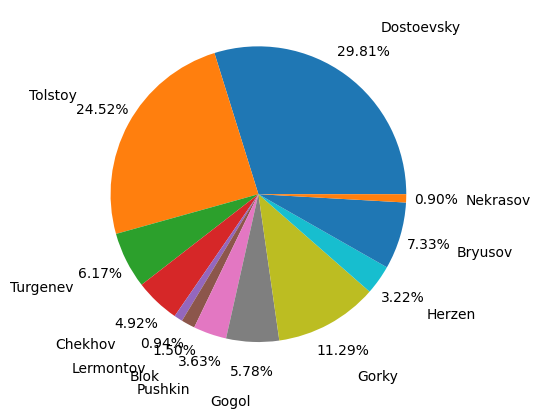

In [ ]:
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train], # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST,                    # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

### Балансировка датасета

После формирования датасета и построения диаграммы общей выборки по писателям
видно, что по количеству слов наш датасет сильно разбалансирован.

Выберем пять авторов с наибольших количеством слов в датасете. Ими являются - Достоевский, Толстой, Горький, Брюсов и Тургенев.

Найдём общее количество слов, среднее значение слов и медианное значение слов выбранных авторов:

In [ ]:
AUTHORS_LIST=["Dostoevsky", "Tolstoy",  "Gorky",  "Bryusov", "Turgenev"]

total_words = 0
for author in CLASS_LIST:
  if author in AUTHORS_LIST:
    cls = CLASS_LIST.index(author)
    total_words += len(seq_train[cls])

mean_list_new = np.array([])
for author in AUTHORS_LIST:
  if author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total_words*100 :.2f}%')
    mean_list_new = np.append(mean_list_new, len(seq_train[cls]))

print('Общее количество слов:', total_words)
print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list_new))

Dostoevsky - 1727703 слов, доля в общей базе: 37.68%
Tolstoy - 1421368 слов, доля в общей базе: 31.00%
Gorky - 654146 слов, доля в общей базе: 14.27%
Bryusov - 424896 слов, доля в общей базе: 9.27%
Turgenev - 357377 слов, доля в общей базе: 7.79%
Общее количество слов: 4585490
Среднее значение слов:  482998.0
Медианное значение слов:  654146.0


Видно, что по количеству слов у выбранных авторов имеется большой разброс. Поэтому мы должны избавиться от "выбросов" как в большую, так и меньшую стороны. Для этого уменьшим в выборке число записей по Достоевскому и Толстому до медианного значения (самого частого в выборке).

Переопределим новый сбалансированный датасет `seq_train_balance` и новые метки`AUTHORS_LIST`.

In [ ]:
median = int(np.median(mean_list_new)) # Зафиксировали медианное значение
seq_train_balance = []
for author in AUTHORS_LIST:
  if author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    seq_train_balance.append(seq_train[cls][:median])

Как видно, мы добавили выбранных авторов в новый датасет и привели к медиане.

In [ ]:
total = sum(len(i) for i in seq_train_balance)

print('Сбалансированная выборка по писателям (по словам):')
mean_list_balance = np.array([])
for author in AUTHORS_LIST:
    cls = AUTHORS_LIST.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list_balance = np.append(mean_list_balance, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list_balance.mean()))
print('Медианное значение слов: ', np.median(mean_list_balance))

Сбалансированная выборка по писателям (по словам):
Dostoevsky - 654146 слов, доля в общей базе: 23.83%
Tolstoy - 654146 слов, доля в общей базе: 23.83%
Gorky - 654146 слов, доля в общей базе: 23.83%
Bryusov - 424896 слов, доля в общей базе: 15.48%
Turgenev - 357377 слов, доля в общей базе: 13.02%
Среднее значение слов:  548942.0
Медианное значение слов:  654146.0


Визализируем на круговой диаграмме распределение по числу слов:

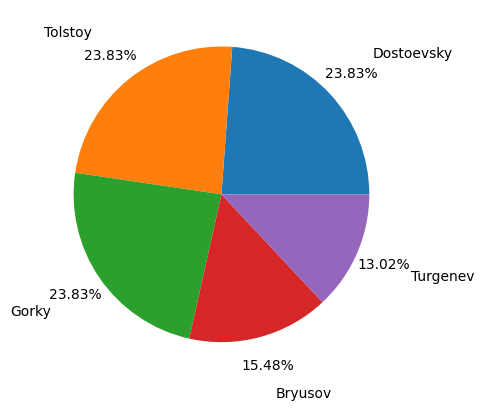

In [ ]:
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance],  # формируем список значений как длина символов текста каждого автора
       labels=AUTHORS_LIST,            # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

Датасет достаточно сбалансирован и можно переходить к процессу получения конечной тренировочной выборки для обучения.

### Создание обучающей, тестовой и проверочной выборок методом скользящего окна

На данный момент весь текст представляет собой одну большую последовательность индексов по каждому писателю. В обучающей выборке должно содержаться большое количество небольших примеров, а у нас один большой. Для подачи в нейросеть этот массив необходимо поделить.

Деление массива на части производится методом "скользящего окна". Для этого задается размер "окна", который определяет число токенов в каждом примере выборки. Например, если размер "окна" равен 10, то каждый пример выборки будет иметь 10 токенов. Смещать "окно" по массиву можно с разным шагом - "шаг окна".

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах

In [ ]:
# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

Напишем функцию векторизации последовательности и создания конечных выборок:

In [ ]:
def seq_vectorize(
    seq_list,   # Последовательность
    test_split, # Доля на тестовую сборку
    val_split,  # Доля на проверочную сборку
    class_list, # Список классов
    win_size,   # Ширина скользящего окна
    step        # Шаг скользящего окна
):

    # Списки для результирующих данных
    x_train, y_train, x_test, y_test, x_val, y_val =  [], [], [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на обучающую и остальные выборки
        gate_split = int(len(seq_list[cls]) * (1-(test_split+val_split)))
        # Пороговое значение индекса для разбивки на тестовую и проверочную выборки
        gate_split_test = int(len(seq_list[cls]) * (1-test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step) # последовательность до первого порога попадет в обучающую выборку
        vectors_test = seq_split(seq_list[cls][gate_split:gate_split_test], win_size, step) # последовательность после первого порога и до второго порога попадет в тестовую выборку
        vectors_val = seq_split(seq_list[cls][gate_split_test:], win_size, step) # последовательность после второго порога попадет в проверочную выборку

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test
        x_val += vectors_val

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train += [utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [utils.to_categorical(cls, len(class_list))] * len(vectors_test)
        y_val += [utils.to_categorical(cls, len(class_list))] * len(vectors_val)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test), np.array(x_val), np.array(y_val)

In [ ]:
x_train, y_train, x_test, y_test, x_val, y_val = seq_vectorize(seq_train_balance, 0.1, 0.1, AUTHORS_LIST, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (21912, 1000)
Форма выходных данных (меток) для обучающей выборки: (21912, 5)


In [ ]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (2698, 1000)
Форма выходных данных (меток) для тестовой выборки: (2698, 5)


In [ ]:
print(f'Форма входных данных для проверочной выборки: {x_val.shape}')
print(f'Форма выходных данных (меток) для проверочной выборки: {y_val.shape}')

Форма входных данных для проверочной выборки: (2698, 1000)
Форма выходных данных (меток) для проверочной выборки: (2698, 5)


### Вспомогательные функции

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Для работы с матрицей ошибок

# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

### Загрузка весов

Загрузим предобученный Embedding:

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2025-04-07 13:52:38--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  9.68MB/s    in 7.0s    

2025-04-07 13:52:47 (7.23 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



Установим библиотеку Navec - библиотека предварительно обученных встраиваний слов для русского языка.

In [ ]:
!pip install navec

In [ ]:
from navec import Navec

navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

Теперь создадим матрицу векторных представлений, которую можно будет передать на вход слоя `Embedding`. Это должна быть матрица с формой `(максимальное число слов, размерность представления)`, каждый элемент `i` которой содержит вектор с размером, равным размерности представления, соответствующий слову с индексом `i` в индексе (созданном в ходе токенизации).

In [ ]:
import numpy as np

embedding_dim = 300
max_words = 20000

embeddings_index = navec

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
print(list(word_index.items())[:10])

[('неизвестное_слово', 0), ('и', 1), ('в', 2), ('не', 3), ('что', 4), ('я', 5), ('на', 6), ('он', 7), ('с', 8), ('как', 9)]


### Архитектура сети

Так как мы используем предварительно сформированные векторные представления, то это накладывает ограничения на размерность входного слоя `Embedding` нашей модели (смотрим по имени файла navec_hudlit_v1_12B_500K_**300d**_100q.tar).

Слой Embedding в качестве весов использует - двумерную матрицу с вещественными числами, каждый `i`-й элемент которой — это вектор, связанный с `i`-м словом в индексе. Все довольно просто. Загрузим подготовленную матрицу в слой `Embedding` с помощью параметра `weights`.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout

model = Sequential()
model.add(Embedding(max_words, embedding_dim, weights=embedding_matrix))
model.add(BatchNormalization())
model.add(Dense(40, activation="relu"))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(len(AUTHORS_LIST), activation='softmax'))

In [ ]:
model.layers[0].trainable = False

Мы также заморозили слой `Embedding` (присвоив атрибуту `trainable` значение
`False`), для того чтобы уже обученные части не изменились в ходе обучения и не потеряли свои знания.

### Обучение модели

Будем использовать небольшой размер пакетов `batch_size`, поскольку используем ограниченное число примеров. Тем более мы еще заберем 10% от обучающей выборки на проверочную выборку.

In [ ]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_val, y_val), callbacks=callbacks)
model.save_weights('pre_trained_model.weights.h5') # можно сохранять не только модели, но и веса

Epoch 1/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5558 - loss: 1.3856 - val_accuracy: 0.8669 - val_loss: 0.4064
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9486 - loss: 0.1526 - val_accuracy: 0.8881 - val_loss: 0.3809
Epoch 3/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9747 - loss: 0.0744 - val_accuracy: 0.8684 - val_loss: 0.6076
Epoch 4/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9843 - loss: 0.0441 - val_accuracy: 0.8614 - val_loss: 0.6570
Epoch 5/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9866 - loss: 0.0424 - val_accuracy: 0.8625 - val_loss: 0.7528
Epoch 6/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9876 - loss: 0.0371 - val_accuracy: 0.9007 - val_loss: 0.4968
Epoch 7/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9896 - loss: 0.0361 - val_accuracy: 0.8629 - val_loss: 0.8015
Epoch 8/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9865 - loss: 0.0505 - val_accuracy: 

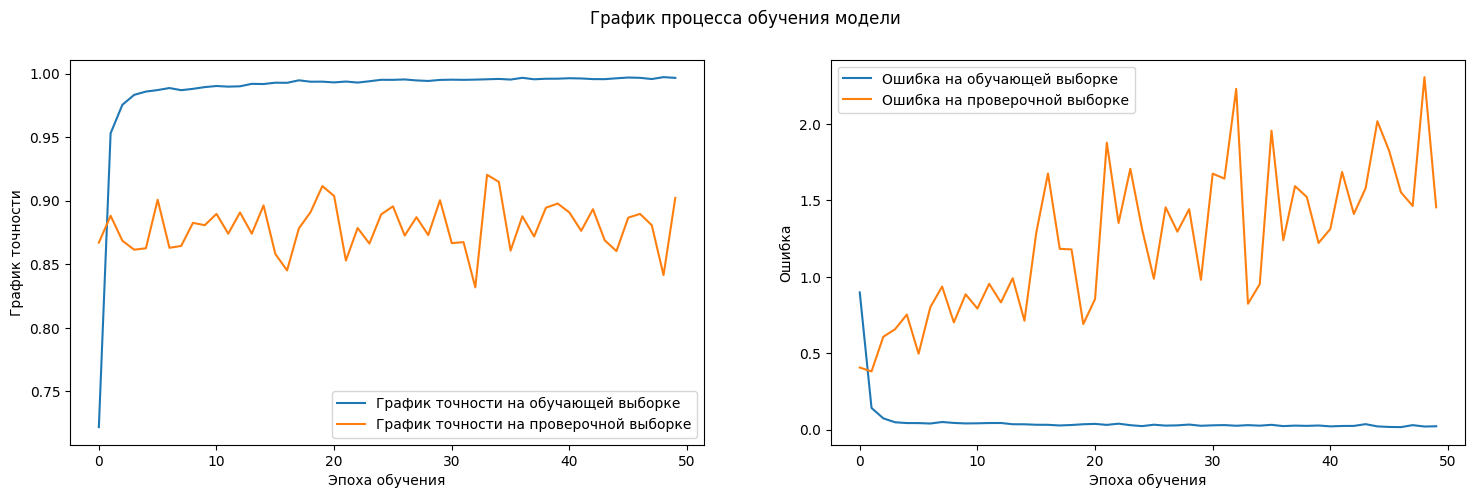

In [ ]:
show_plot(history)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


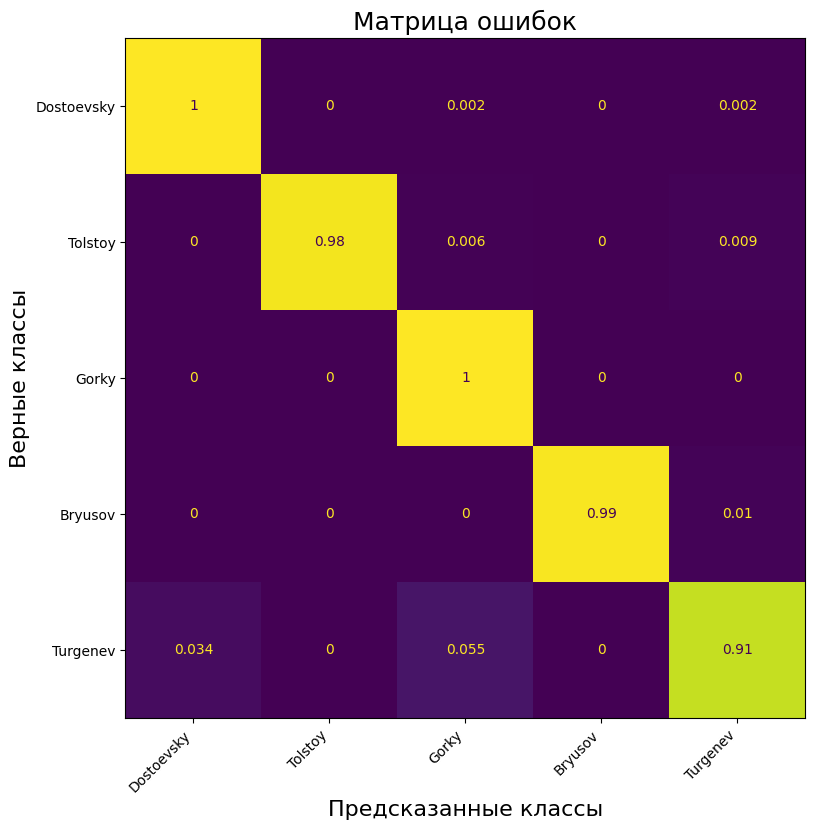


Средняя точность распознавания:  98%


In [ ]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, AUTHORS_LIST)

### **ВЫВОД**
По результатам обучения модели видно что, при использовании токенизатора Razdel и размере словаря в (65, 65, 65, 42 и 35 тыс. слов), точность на обучающей выборке достигла 99,7%, на проверочной 92% на лучшей эпохе. При этом средняя точность на тестовых образцах составила всего 98% (рассчитанная по диагонали матрицы ошибок).
Модель отлично справляется с поставленной задачей!